# Collaborative Filtering for Implicit Feedback Datasets

## Methodology

A utility matrix $R$ was constructed, with `producers vector` $p$ rows and sampled artist vector $a$ columns. $R_{p,a}$ represents the number of times a given producer $p$ sampled an artist $a$, ranging from 0 to 131.

Singular Value Decomposition is a latent factor model which causes dimensionality reduction. Two matrices are created, a user-factor matrix and an item-factor matrix, where the factor represents the number of latent factors in the data. The dot product of these matrices is a prediction of whether or not a user will interact with a item. Originally, these models were trained by stochastic gradient descent, in the form of the equation below:

$\underset{x,y}min\underset{u,i}\sum 
c_{ui} (p_{ui} - x_u^Ty_i)^2 + \lambda
(\underset u \sum \parallel x_u \parallel ^2
+\underset u \sum \parallel y_i \parallel ^2)$

##### Where:

* $x_u$ is user vector
* $y_i$ is item vector
* $x_u^Ty_i$ is their dot product.

* $p_{ui} = 1$ if interaction, 0 if no interaction.

* $c_{ui} =$ our confidence in the data; in our case, the number of times a producer sampled a artist. This is calculated as $c_{ui} =1 + \alpha * r_{ui}$, where
$r_{ui}$ = # of interactions for a user-item pair, and $\alpha$ determines our confidence levels.

* $\lambda$ is regularization term.

The difference between $p_{ui)$ and the dot product of user vector and item vector is the error that gradient descent attempts to minimize. Errors where we are highly confident about the interaction (multiple purchases of an item, for instance) are penalized higher, by multplying the error by the number of interactions.

Like other gradient descent algorithms, this model begins with taking the squared error of our prediction $(p_{ui} - x_u^Ty_i)^2$. It then multiplies our error by our confidence in this prediction, $c_{ui}$, thus increasing the cost of errors on high confidence user-item interactions. Across all or a subset of users x and items y, we minimize this cost.

In practice, however, stochastic gradient descent is impossible in implicit feedback. There are often billions of user-item interactions to compute over.

## ALS

Therefore we modify the cost function to Alternating Least Squares, which works by holding either user vectors or item vectors constant and calculating the global minimum, then alternating to the other vector.

### Compute User factors
$x_u = (Y^T C^u Y + \lambda I)^{-1}  Y^T C^u p(u)$

##### Where:

$Y$ is $n * f$ matrix of item-factors. 

$C^u$ is a $n*n$ diagonal matrix for user $u$ where $C^u_{ii} = c_{ui}$. Each $C^u$ is our confidence matrix for $n$ items for $u$ user.

$p(u)$ is vector of preferences for user $u$.

### Recompute Item factors

$y_i = (X^TC^iX + \lambda I)^-1 X^TC^ip(i)$

##### Where:
$X$ = $m * f$ matrix  of user_factors. 

$C^i$ is $m * m$ diagonal matrix for each item $i$ where $C_{uu}^i = c_{ui}$

$p(i)$ is vector of preferences for item $i$.


### Explaining recommendations

If $\hat{p}_{ui}$, the predicted preference of user $u$ at item $i$, is equal to $y_i^Tx_u$, we can substite our user_factor equation for $x_u$. This gives us:

$\hat{p}_{ui} =  y_i^T(Y^T C^u Y + \lambda I)^{-1}  Y^T C^u p(u)$

Denote $f*f$ matrix $(Y^T C^u Y + \lambda I)^{-1}$ as $W^u$

$W^u$ is considered the weight for user $u$


## Import libraries

In [1]:
from pymongo import MongoClient
client = MongoClient()
db = client.whosampled
import numpy as np
import pandas as pd

import implicit
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import scipy.sparse as sparse
from scipy.sparse import csr_matrix

import os, sys
os.environ["OPENBLAS_NUM_THREADS"]="1"

import random

np.set_printoptions(threshold=sys.maxsize)
pd.options.display.max_seq_items = 10000
from src.test_ranking import *

%reload_ext autoreload

## Read in the data from the Mongo collection

In [2]:
df = clean_up_mongo_coll(db.main_redo)

## Turn df to utility matrix

In [3]:
user_art = turn_df_to_util_mat(
    df, 'new_song_producer', 'sampled_artist')

### Perform Test/Train Split

We can't do a traditional 70/30 split for recommendation systems, because the algorithm requires the entire
dataframe to train on. Instead, we create a test set by taking some percentage of the actual interactions, and 
replacing them with zeros- in other words, acting as if the producer has not sampled those artists.

We keep track of the values that were changed to zeros in `user_inds` and `item_inds`.

We train the model on this `train` dataset with these specific values hidden. 

In [4]:
user_inds, item_inds = get_indices_of_test_set_values(user_art, 5)

train, test = make_train_set_and_test_set(user_inds, item_inds, user_art)

## Fit model on training data 

The implicit library has a fast implementation of the alternating least squares algorithm, which I use below. 

The model's fit method expects the sparse utility matrix to be as item/user- however, ours is in user-item.

Therefore, the model's item_vecs is our user_vecs, and vice versa.

## Test model

We need a metric to evaluate how our model is performing on the test data.
### Ranking Algorithm

$\overline{rank} = \frac{\sum_{u,i} r^t_{ui} * rank_{ui}}{\sum_{u,i} r^t_{ui}}$

#### where:
$r^t_{ui}$ is the # of interactions for observations in the test set.

$rank_{ui}$ are the percentile ranking of each item for each user.

#### Explanation

We can see that $\sum_{u,i} r^t_{ui}$ is in both the numerator and the denominator. If $rank_{ui}$ was not in the numerator, $\overline{rank}$ would simply equal 1. $rank_{ui}$ is the percentile ranking of each item for each user, such that the item most highly recommended has a $rank_{ui}$ of 0.00\% and the item least recommended has a $rank_{ui}$ of 100.00\%.

Therefore, if the algorithm is correct, the low percentages will cancel out the higher $r^t_{ui}$, making the $\overline{rank}$ go towards 0.

The item most highly recommended has a $rank_{ui}$ of 0.00\% and the item least recommended has a $rank_{ui}$ of 100.00\%.
$rank_{ui}$ spans from 0 to 1

#### Methodology

1. Get denominator by summing the # of user-item interactions at the test set indices. This is $\sum_{u,i} r^t_{ui}$, for  $\overline{rank} = \frac{\sum_{u,i} r^t_{ui} * rank_{ui}}{\sum_{u,i} r^t_{ui}}$   

2. Get the $rank_{ui}$ of our model for all $u, i$ in $r^t_{ui}$. This is calculated by getting the predictions of the ALS model, ranking them, taking their percentage, and then selecting only the ones at the selected indices.

3. Get $r^t_{ui}$ : This is just all of the values at the user-item interactions at the test set indices. Most are 1, for when a producer sampled an artist once, but some are higher.

4. Multiply $rank_{ui}$ by $r^t_{ui}$ and sum this vector to get numerator. Divide by $\sum_{u,i} r^t_{ui}$ to get $\overline{rank}$

5. Use popularity as a baseline for the model. Instead of using the model to rank different songs for artists, rank them by the number of times they've been sampled in total, and then select the rankings for songs at our test indices. This is $poprank_{ui}$. Input as $\overline{rank} = \frac{\sum_{u,i} r^t_{ui} * poprank_{ui}}{\sum_{u,i} r^t_{ui}}$

## Putting it all together

In Yuwan He's paper, they say that more factors is better without fail.
So I originally try to run the model with 400 factors.

In [5]:
rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
    train, test, user_inds, item_inds, 400)

print(
"Model rank score: {} \n\
Popularity rank score: {}".format(rank_score, pop_rank_score))



100%|██████████| 50.0/50 [01:03<00:00,  1.26s/it]


Model rank score: 0.1657164078818192 
Popularity rank score: 0.09186153323220778


In [7]:
pd.DataFrame({"Model Rank Score": [round(rank_score, 3)], 
                     "Popularity Rank Score" : [round(pop_rank_score, 3)]})

,Model Rank Score,Popularity Rank Score
0,0.166,0.092


The rank_score is nearly the same as good as popularity immediately.

## Filter Training Set by Users or Items with >n interactions

One possible reason I am failing to beat popularity is because the model is having to train on producers with few artists sampled, and artists who have been sampled infrequently.

For instance, 467 producers have 0 samples in the training set, and 9240 have only 1 sample to learn from. 286 artists in the training set were never sampled, and 4727 were only sampled once.



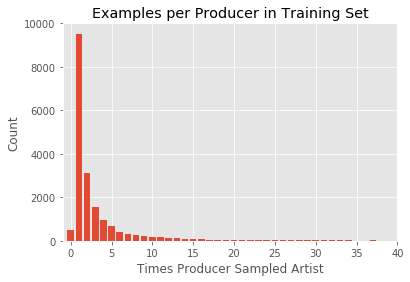

In [320]:
#Plot number interactions 

samples_per_prod = train.sum(axis = 1)
counts = samples_per_prod.value_counts().sort_index()

fig, ax = plt.subplots()
ax.set(ylim = (0,10000), xlim = (-1, 40), 
       title = "Examples per Producer in Training Set",
       xlabel = "Times Producer Sampled Artist", 
       ylabel = "Count")
# ax.axvline(5, color ='black')
_ = ax.bar(counts.index, counts.values)

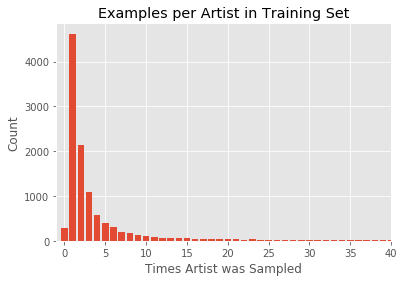

In [321]:
times_sampled_by_artist = train.sum(axis = 0)
counts = times_sampled_by_artist.value_counts().sort_index()

fig, ax = plt.subplots()
ax.set(xlim = (-1, 40), 
       title = "Examples per Artist in Training Set",
       xlabel = "Times Artist was Sampled", 
       ylabel = "Count")
# ax.axvline(5, color ='black')
_ = ax.bar(counts.index, counts.values)

## Therefore I do my grid search only with producers and artists with at least 2 interactions.

I am grid searching these parameters: Numbers of factors, lambda, and iterations.

In [5]:
# Parameters that will be grid searched.

#factors
fa = list(range(4, 20, 4))
fb = list(range(20,460, 60))
factors = fa + fb

#regularizations
ra = list(np.logspace(-2, 4, 7))
rb = list(range(30,100, 15))
regularizations = ra + rb

#iterations
iterations = list(range(15, 90, 30))
iterations.append(300)

#limit training and test set to have at least 2 examples to train on.

#initialize empty list to store params and scores
grid_search = []

for factor in factors:
    for regularization in regularizations:
        for iteration in iterations:
            rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
            train_lim, test_lim, user_inds_lim, item_inds_lim, factor, regularization, iteration)
            
            grid_search.append([factor, regularization, iteration, rank_score, pop_rank_score])

columns = ['factors', 'regularization', 'iterations', 'rank_score', 
                    'pop_score']

grid_search_three_params = pd.DataFrame(grid_search, columns = columns)

grid_search_three_params.to_csv("grid_search_three_params.csv")

100%|██████████| 15.0/15 [00:00<00:00, 28.64it/s]
100%|██████████| 45.0/45 [00:01<00:00, 31.63it/s]
100%|██████████| 75.0/75 [00:02<00:00, 31.77it/s]
100%|██████████| 300.0/300 [00:09<00:00, 32.64it/s]
100%|██████████| 15.0/15 [00:00<00:00, 32.17it/s]
100%|██████████| 45.0/45 [00:01<00:00, 30.96it/s]
100%|██████████| 75.0/75 [00:02<00:00, 32.02it/s]
100%|██████████| 300.0/300 [00:09<00:00, 31.66it/s]
100%|██████████| 15.0/15 [00:00<00:00, 29.88it/s]
100%|██████████| 45.0/45 [00:01<00:00, 30.06it/s]
100%|██████████| 75.0/75 [00:02<00:00, 30.85it/s]
100%|██████████| 300.0/300 [00:09<00:00, 31.58it/s]
100%|██████████| 15.0/15 [00:00<00:00, 31.77it/s]
100%|██████████| 45.0/45 [00:01<00:00, 31.31it/s]
100%|██████████| 75.0/75 [00:02<00:00, 32.14it/s]
100%|██████████| 300.0/300 [00:09<00:00, 32.26it/s]
100%|██████████| 15.0/15 [00:00<00:00, 30.41it/s]
100%|██████████| 45.0/45 [00:01<00:00, 31.95it/s]
100%|██████████| 75.0/75 [00:02<00:00, 32.12it/s]
100%|██████████| 300.0/300 [00:09<00:00, 3

100%|██████████| 15.0/15 [00:05<00:00,  2.73it/s]
100%|██████████| 45.0/45 [00:14<00:00,  3.10it/s]
100%|██████████| 75.0/75 [00:25<00:00,  2.76it/s]
100%|██████████| 300.0/300 [01:36<00:00,  3.26it/s]
100%|██████████| 15.0/15 [00:04<00:00,  3.08it/s]
100%|██████████| 45.0/45 [00:14<00:00,  2.70it/s]
100%|██████████| 75.0/75 [00:23<00:00,  3.20it/s]
100%|██████████| 300.0/300 [01:39<00:00,  3.17it/s]
100%|██████████| 15.0/15 [00:04<00:00,  3.17it/s]
100%|██████████| 45.0/45 [00:14<00:00,  2.84it/s]
100%|██████████| 75.0/75 [00:25<00:00,  2.77it/s]
100%|██████████| 300.0/300 [01:35<00:00,  3.48it/s]
100%|██████████| 15.0/15 [00:06<00:00,  2.60it/s]
100%|██████████| 45.0/45 [00:17<00:00,  2.35it/s]
100%|██████████| 75.0/75 [00:31<00:00,  2.09it/s]
100%|██████████| 300.0/300 [02:07<00:00,  2.67it/s]
100%|██████████| 15.0/15 [00:06<00:00,  2.20it/s]
100%|██████████| 45.0/45 [00:18<00:00,  2.52it/s]
100%|██████████| 75.0/75 [00:30<00:00,  2.47it/s]
100%|██████████| 300.0/300 [02:06<00:00,  

## Get best value from grid search, and use for prod_lim/ art_lim search 

In [10]:
min_idx = grid_search_three_params.rank_score.idxmin()

best_factors = grid_search_three_params.factors.iloc[min_idx]

best_lambda = grid_search_three_params.regularization.iloc[min_idx]

best_iters = grid_search_three_params.iterations.iloc[min_idx]

In [9]:
grid_search_three_params.iloc[min_idx]

factors           20.000000
regularization    30.000000
iterations        45.000000
rank_score         0.090144
pop_score          0.080133
Name: 221, dtype: float64

## Remove producers/ artists with less than 2 examples in dataset. 

Create a dataframe with # users, # items, sparsity, rank_score, pop_rank_score, % users, % items.

At >2 interactions for both artist and producer, rank_score drops to 0.113241

In [19]:
rows = []
i = 1
for user_lim in range(-1, 6):
    for item_lim in range(-1, 6):
        
        # filter the training/ test dataset to have >n interactions
        train_lim, test_lim, user_inds_lim, item_inds_lim = filter_dataset_by_requisite_interactions(
        train, test, user_lim, item_lim)
        
        # get sparsity of the training dataset.
        sparsity = get_sparsity_of_training_data(train_lim)
        
        # see how many users/ items were lost by decreasing 
        num_users_at_lim = train_lim.shape[0]
        num_items_at_lim = train_lim.shape[1]
        
        percent_users_lost = 100 * (1 - (num_users_at_lim / train.shape[0]))
        percent_items_lost = 100 * (1 - (num_items_at_lim / train.shape[1]))
        
        rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
            train_lim, test_lim, user_inds_lim, item_inds_lim, best_factors, best_lambda, best_iters)
        
        rows.append([user_lim, item_lim, num_users_at_lim, num_items_at_lim, 
                    sparsity, percent_users_lost, percent_items_lost, 
                   rank_score, pop_rank_score])
        
        print("You're at number {} of 100, this one has {} sparsity".format(i, sparsity))
        
        i = i + 1
        
columns = ['user_lim', 'item_lim', 'num_users_at_lim', 'num_items_at_lim', 
                    'sparsity', 'percent_users_lost', 'percent_items_lost', 
                   'rank_score', 'pop_rank_score']

statistics_at_interaction_limits = pd.DataFrame(rows, columns = columns)

statistics_at_interaction_limits.to_csv("statistics_at_interaction_limits.csv")

100%|██████████| 45.0/45 [00:13<00:00,  3.23it/s]


You're at number 1 of 100, this one has 99.94860942319838 sparsity


100%|██████████| 45.0/45 [00:13<00:00,  3.22it/s]


You're at number 2 of 100, this one has 99.94746107657424 sparsity


100%|██████████| 45.0/45 [00:11<00:00,  4.05it/s]


You're at number 3 of 100, this one has 99.91516040620135 sparsity


100%|██████████| 45.0/45 [00:10<00:00,  4.29it/s]


You're at number 4 of 100, this one has 99.87994418598724 sparsity


100%|██████████| 45.0/45 [00:09<00:00,  4.58it/s]


You're at number 5 of 100, this one has 99.8452789662834 sparsity


100%|██████████| 45.0/45 [00:09<00:00,  4.72it/s]


You're at number 6 of 100, this one has 99.81658373426365 sparsity


100%|██████████| 45.0/45 [00:09<00:00,  4.86it/s]


You're at number 7 of 100, this one has 99.79211700027781 sparsity


100%|██████████| 45.0/45 [00:13<00:00,  3.24it/s]


You're at number 8 of 100, this one has 99.94732576750206 sparsity


100%|██████████| 45.0/45 [00:13<00:00,  3.34it/s]


You're at number 9 of 100, this one has 99.94614873698728 sparsity


100%|██████████| 45.0/45 [00:11<00:00,  3.99it/s]


You're at number 10 of 100, this one has 99.91304124672446 sparsity


100%|██████████| 45.0/45 [00:10<00:00,  4.25it/s]


You're at number 11 of 100, this one has 99.87694538077577 sparsity


100%|██████████| 45.0/45 [00:10<00:00,  4.54it/s]


You're at number 12 of 100, this one has 99.84141427846261 sparsity


100%|██████████| 45.0/45 [00:09<00:00,  4.70it/s]


You're at number 13 of 100, this one has 99.81200228472635 sparsity


100%|██████████| 45.0/45 [00:09<00:00,  4.91it/s]


You're at number 14 of 100, this one has 99.78692441024735 sparsity


100%|██████████| 45.0/45 [00:10<00:00,  4.55it/s]


You're at number 15 of 100, this one has 99.908832197511 sparsity


100%|██████████| 45.0/45 [00:09<00:00,  4.69it/s]


You're at number 16 of 100, this one has 99.90679501005889 sparsity


100%|██████████| 45.0/45 [00:08<00:00,  5.69it/s]


You're at number 17 of 100, this one has 99.84955513512008 sparsity


100%|██████████| 45.0/45 [00:07<00:00,  6.26it/s]


You're at number 18 of 100, this one has 99.78715732905385 sparsity


100%|██████████| 45.0/45 [00:07<00:00,  6.48it/s]


You're at number 19 of 100, this one has 99.72567372627475 sparsity


100%|██████████| 45.0/45 [00:06<00:00,  7.23it/s]


You're at number 20 of 100, this one has 99.67487185229422 sparsity


100%|██████████| 45.0/45 [00:06<00:00,  7.31it/s]


You're at number 21 of 100, this one has 99.63142549032648 sparsity


100%|██████████| 45.0/45 [00:08<00:00,  5.23it/s]


You're at number 22 of 100, this one has 99.87611375308228 sparsity


100%|██████████| 45.0/45 [00:08<00:00,  5.52it/s]


You're at number 23 of 100, this one has 99.8733454565914 sparsity


100%|██████████| 45.0/45 [00:06<00:00,  6.76it/s]


You're at number 24 of 100, this one has 99.79563241482316 sparsity


100%|██████████| 45.0/45 [00:05<00:00,  7.75it/s]


You're at number 25 of 100, this one has 99.7108431181757 sparsity


100%|██████████| 45.0/45 [00:05<00:00,  8.22it/s]


You're at number 26 of 100, this one has 99.62723758380886 sparsity


100%|██████████| 45.0/45 [00:05<00:00,  8.54it/s]


You're at number 27 of 100, this one has 99.55816045305184 sparsity


100%|██████████| 45.0/45 [00:05<00:00,  8.81it/s]


You're at number 28 of 100, this one has 99.49923547472075 sparsity


100%|██████████| 45.0/45 [00:07<00:00,  6.01it/s]


You're at number 29 of 100, this one has 99.84464493637692 sparsity


100%|██████████| 45.0/45 [00:07<00:00,  5.96it/s]


You're at number 30 of 100, this one has 99.84117345436687 sparsity


100%|██████████| 45.0/45 [00:06<00:00,  7.43it/s]


You're at number 31 of 100, this one has 99.74392181844594 sparsity


100%|██████████| 45.0/45 [00:05<00:00,  7.87it/s]


You're at number 32 of 100, this one has 99.63769966431025 sparsity


100%|██████████| 45.0/45 [00:04<00:00,  9.32it/s]


You're at number 33 of 100, this one has 99.53303011816983 sparsity


100%|██████████| 45.0/45 [00:04<00:00,  9.30it/s]


You're at number 34 of 100, this one has 99.44654115918738 sparsity


100%|██████████| 45.0/45 [00:05<00:00,  7.51it/s]


You're at number 35 of 100, this one has 99.3728033103371 sparsity


100%|██████████| 45.0/45 [00:08<00:00,  5.15it/s]


You're at number 36 of 100, this one has 99.81302879078974 sparsity


100%|██████████| 45.0/45 [00:12<00:00,  3.70it/s]


You're at number 37 of 100, this one has 99.8088508311273 sparsity


100%|██████████| 45.0/45 [00:06<00:00,  6.26it/s]


You're at number 38 of 100, this one has 99.69198901390418 sparsity


100%|██████████| 45.0/45 [00:06<00:00,  7.01it/s]


You're at number 39 of 100, this one has 99.56421555596879 sparsity


100%|██████████| 45.0/45 [00:05<00:00,  7.67it/s]


You're at number 40 of 100, this one has 99.4383091766479 sparsity


100%|██████████| 45.0/45 [00:05<00:00,  8.30it/s]


You're at number 41 of 100, this one has 99.33434460437964 sparsity


100%|██████████| 45.0/45 [00:05<00:00,  8.22it/s]


You're at number 42 of 100, this one has 99.24575918241396 sparsity


100%|██████████| 45.0/45 [00:08<00:00,  5.41it/s]


You're at number 43 of 100, this one has 99.7837652071134 sparsity


100%|██████████| 45.0/45 [00:08<00:00,  5.46it/s]


You're at number 44 of 100, this one has 99.77893333890165 sparsity


100%|██████████| 45.0/45 [00:08<00:00,  5.26it/s]


You're at number 45 of 100, this one has 99.64392324354704 sparsity


100%|██████████| 45.0/45 [00:05<00:00,  7.80it/s]


You're at number 46 of 100, this one has 99.49622840463522 sparsity


100%|██████████| 45.0/45 [00:04<00:00,  8.76it/s]


You're at number 47 of 100, this one has 99.35073013757332 sparsity


100%|██████████| 45.0/45 [00:04<00:00,  8.56it/s]


You're at number 48 of 100, this one has 99.2305450861637 sparsity


100%|██████████| 45.0/45 [00:04<00:00,  9.72it/s]


You're at number 49 of 100, this one has 99.12815828504952 sparsity


In [21]:
statistics_at_interaction_limits['total lost'] =statistics_at_interaction_limits.percent_users_lost + statistics_at_interaction_limits.percent_items_lost

In [25]:
statistics_at_interaction_limits["Beat Popularity?"] = statistics_at_interaction_limits.rank_score < \
statistics_at_interaction_limits.pop_rank_score

In [331]:
statistics_at_interaction_limits

,user_lim,item_lim,num_users_at_lim,num_items_at_lim,sparsity,percent_users_lost,percent_items_lost,rank_score,pop_rank_score,total lost,Beat Popularity?
0,-1,-1,21379,12719,99.948609,0.000000,0.000000,0.148091,0.094152,0.000000,False
1,-1,0,21379,12441,99.947461,0.000000,2.185706,0.121631,0.066840,2.185706,False
2,-1,1,21379,7428,99.915160,0.000000,41.599182,0.131123,0.085442,41.599182,False
3,-1,2,21379,5065,99.879944,0.000000,60.177687,0.141778,0.102126,60.177687,False
4,-1,3,21379,3817,99.845279,0.000000,69.989779,0.153529,0.119835,69.989779,False
5,-1,4,21379,3152,99.816584,0.000000,75.218178,0.158822,0.128446,75.218178,False
6,-1,5,21379,2734,99.792117,0.000000,78.504599,0.161596,0.135221,78.504599,False
7,0,-1,20858,12719,99.947326,2.436971,0.000000,0.120655,0.094783,2.436971,False
8,0,0,20858,12441,99.946149,2.436971,2.185706,0.092127,0.067041,4.622677,False
9,0,1,20858,7428,99.913041,2.436971,41.599182,0.101230,0.084898,44.036153,False


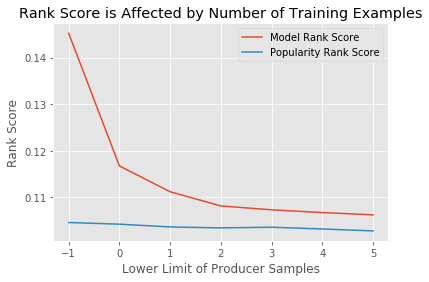

In [339]:
yo = statistics_at_interaction_limits.groupby('user_lim').mean()

fig, ax = plt.subplots()
ax.set(title = "Rank Score is Affected by Number of Training Examples",
       xlabel = "Lower Limit of Producer Samples", 
       ylabel = "Rank Score")
# ax.axvline(5, color ='black')
ax.plot(yo.index, yo.rank_score, label = "Model Rank Score")
ax.plot(yo.index, yo.pop_rank_score, label = "Popularity Rank Score")
_ = ax.legend(loc = 'best')

## Plot results in Plotly

In [317]:
import plotly
import plotly.graph_objs as go

data = go.Scatter3d(
    x= np.array(statistics_at_interaction_limits.user_lim),
    y= np.array(statistics_at_interaction_limits.item_lim),
    z= np.array(statistics_at_interaction_limits.rank_score),
    mode='markers',
    name = 'Model Rank Score',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

data2 = go.Scatter3d(
    x= np.array(statistics_at_interaction_limits.user_lim),
    y= np.array(statistics_at_interaction_limits.item_lim),
    z= np.array(statistics_at_interaction_limits.pop_rank_score),
    mode='markers',
    name = 'Popular Rank Score',
    marker=dict(
        size=12,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8

    )
)
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    ), showlegend=True,
    scene = dict(
    xaxis = dict(
        title='Lower Limit of Samples By Producer'),
    yaxis = dict(
        title='Lower Limit of Artist Samples'),
    zaxis = dict(
        title='Rank Score')))
    

fig = go.Figure(data=[data, data2], layout=layout)
plotly.offline.plot(fig)

'file:///Users/jesse/Documents/recordmender/temp-plot.html'

## Explore Model

In [8]:
#Train model on entire dataset to examine its parameters

# filter so at least 6 samples per producer and at least 1 sample per artist.
user_art1, _, user_inds_lim, item_inds_lim = filter_dataset_by_requisite_interactions(
        user_art, user_art, 5, 0)

#flip so that its item_user, so that the recommend method works
artist_user = user_art1.T 

model = implicit.als.AlternatingLeastSquares(
        factors=best_factors, iterations=best_iters, regularization= best_lambda)

# train the model on a sparse matrix of item/user/confidence weights
sparse_art_user = csr_matrix(artist_user)
model.fit(sparse_art_user)

# calculate predictions

predictions_art_user = model.user_factors.dot(model.item_factors.T).T

NameError: name 'best_factors' is not defined

In [431]:
def get_similar_to_prod(user, n_similar, model, artist_user):
    
    # Get index of user 
    index_of_user = artist_user.columns.get_loc(user)
    
    similar_users = model.similar_users(index_of_user, N= n_similar)
    
    similar_user_inds = [sim[0] for sim in similar_users]
    
    return [artist_user.columns[n] for n in similar_user_inds]

In [466]:
pd.DataFrame(get_similar_to_prod("The Alchemist", 10, model, artist_user)[1:],
             columns = ['Producers Most Similar to Timbaland'])

,Producers Most Similar to Timbaland
0,Sebb
1,Stu Bangas
2,Evidence
3,Hordatoj
4,"Davel ""Bo"" McKenzie"
5,Chinky P
6,Mastafive
7,SBe Audiologist
8,Guts


In [483]:
artist_user.index[7653]

'Myra Barnes'

In [477]:
artist_user.index.get_loc("Tom Scott")

11735

In [413]:
artist_user.columns.get_loc("Kanye West")

2124

In [478]:
model.similar_items(11735)

[(11735, 0.4973827),
 (12566, 0.46476853),
 (10771, 0.4638043),
 (10886, 0.46277383),
 (4336, 0.44847843),
 (5871, 0.44821966),
 (837, 0.44517156),
 (11434, 0.44486147),
 (7653, 0.44289082),
 (668, 0.44242132)]

In [301]:
user_art1.sum(axis = 1).sort_values(ascending = False)

new_song_producer
Madlib                      1168
9th Wonder                   981
J Dilla                      953
The Alchemist                822
Pete Rock                    809
DJ Premier                   736
DJ Paul                      722
Dr. Dre                      664
Juicy J                      632
Kanye West                   630
RZA                          607
Marley Marl                  562
Prince Paul                  477
Erick Sermon                 469
Statik Selektah              436
Buckwild                     435
Diamond D                    395
Knxwledge.                   378
DJ Muggs                     365
Jermaine Dupri               359
Timbaland                    355
Teddy Riley                  321
Large Professor              294
Salaam Remi                  293
will.i.am                    290
No I.D.                      285
Harry Fraud                  283
Guru                         280
Ice Cube                     279
The Beatnuts             

## Split df by element sampled

Should we put interpolations in there? Not now.

In [215]:
elements = ["Direct Sample of Vocals / Lyrics", 
            'Direct Sample of Drums',
            'Direct Sample of Multiple Elements']
rank_scores = []

pop_scores = []

for element in elements:
    #filter df by element
    df_elem = df[df.elements_sampled == element]

    #turn to utility
    user_art_elem = turn_df_to_util_mat(
        df_elem, 'new_song_producer', 'sampled_artist')
    
    #make train and test sets
    user_inds_elem, item_inds_elem = get_indices_of_test_set_values(user_art_elem, 5)
    train_elem, test_elem = make_train_set_and_test_set(user_inds_elem, item_inds_elem, user_art_elem)
    
    train_elem, test_elem, user_inds_elem, item_inds_elem = filter_dataset_by_requisite_interactions(
        train_elem, test_elem, 5, 0)
    rank_score, pop_score = get_rank_and_pop_score_from_train_test_model(
        train_elem, test_elem, user_inds_elem, item_inds_elem, factors = best_factors, regularization = best_lambda, iterations = best_iters)
    rank_scores.append(rank_score)
    pop_scores.append(pop_score)


100%|██████████| 45.0/45 [00:01<00:00, 25.55it/s]
100%|██████████| 45.0/45 [00:00<00:00, 70.45it/s]
100%|██████████| 45.0/45 [00:03<00:00, 14.82it/s]


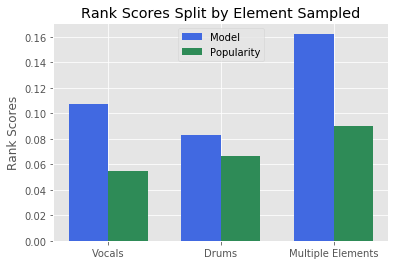

In [216]:
labels = [ 'Vocals', 'Drums', 'Multiple Elements']

N = 3

ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure()
ax = fig.add_subplot(111)
rects1 = ax.bar(ind, rank_scores, width, color='royalblue')
rects2 = ax.bar(ind+width, pop_scores, width, color='seagreen')

# add some
ax.set_ylabel('Rank Scores')
ax.set_title('Rank Scores Split by Element Sampled')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels( labels )

_ = ax.legend( (rects1[0], rects2[0]), ('Model', 'Popularity'), loc = 'upper center' )

# Feature Engineering - Can it recommend a year? An album?

In [37]:
def get_rank_and_pop_score_of_two_columns(df, col1, col2, split_pct, factors = 10, regularization = 74, iterations = 50):
    
    '''
    Input: 
        Col1: Users
        Col2: Items
        Df: Dataframe to get columns data from
        Split.pct: % of data to send to hide for testing.
        Factors, regularization, iterations: Parameters for the ALS algorithm
        
    Returns: Rank_score and pop_score of those two columns
    '''
    
    user_item = turn_df_to_util_mat_at_limits(
            df, col1, col2)

    user_inds, item_inds = get_indices_of_test_set_values(user_item, split_pct)

    train, test = make_train_set_and_test_set(user_inds, item_inds, user_item)

    rank_score, pop_rank_score = get_rank_and_pop_score_from_train_test_model(
        train, test, user_inds, item_inds, factors, regularization ,iterations)
    
    return rank_score, pop_rank_score

## Try with sampled_song

It's possible (?) that the recommender will work better to recommend songs to sample, not artists. Unlikely.

Also maybe it will find a better relationship between new_song_artist and sampled_song_artist, or new_song_artist and sampled_song

We would also need to grid search this. 

### Album

In [ ]:
rank_score_album, pop_rank_score_album = get_rank_and_pop_score_of_two_columns(df, 'new_song_producer', 'sampled_song_album', 5)

print(
    "Model rank score: {} \n\
    Popularity rank score: {}".format(rank_score, pop_rank_score))
    

## Year

## Repeat the above, but with new_song_artist instead of new_song_producer

## Logged Data

Hu's paper, they log transfomed the data by following this paper:
“Item-based top-N recom-mendation algorithms" - M DESHPANDE - 2004

They mention two strategies:

1. Multiply $P(j|i)$ by $−log_2(P(j))$ [Salton 1989] 

2. Divide $P(j|i)$ by $P(j)$ [Kitts et al. 2000].

But first they have to do:

$P(j|i)$ is the number of customers that purchase both items $i$ and $j$ divided by the total number of customers that purchased $i$, that is,
$P(j|i)= Freq(ij), Freq(i)$
where $Freq(X)$ is the number of customers that have purchased the items in the set X.

In [ ]:
import math
artist_prod_log = artist_prod.applymap(lambda x: math.log(x, 30) if x != 0 else 0)
plot_distributions_of_numbers_sampled(artist_prod_log, 'Log')

#log 10 still looks very skewed.
#they used log 6.
#Log 20 still skewed.

## Go through None Listed on producers

#### How many have all None Listed?
33 percent have none Listed for producers!

If they have None Listed for contributor (about 40), that probably means it failed. Because contributor is always listed.

Certain artists have more none listed than others.

Nearly 1/2 of the cells with missing producers are where the artist occurs less than 5 times in the df.

From the pie chart, nearly 3/4 of the missing producers are from artists who appear only 3 or less times in the dataset.



In [25]:
df = pd.DataFrame(list(db.main_redo.find()))


In [26]:
for col in df.columns:
    print("{} has {} with None Listed".format(col, len(df[df[col] == "None Listed" ])))

URL has 0 with None Listed
_id has 0 with None Listed
contributor_points has 56 with None Listed
elements_sampled has 52 with None Listed
name_of_contributor has 56 with None Listed
new_song_album has 20914 with None Listed
new_song_artist has 48 with None Listed
new_song_name has 48 with None Listed
new_song_producer has 70996 with None Listed
new_song_year has 49 with None Listed
presence_of_"and throughout"_in_description has 17060 with None Listed
sampled_artist has 1331 with None Listed
sampled_song_album has 22981 with None Listed
sampled_song_name has 1331 with None Listed
sampled_song_producer has 7 with None Listed
sampled_song_year has 3386 with None Listed
time_in_sampled_song_where_sample_appears has 17066 with None Listed


In [27]:
#Remove rows without artist, there's about 30
df = df[df.new_song_artist != "None Listed"]

In [37]:
df.URL[df.new_song_artist == "Marie Myriam"]

91697    https://www.whosampled.com/cover/624116/Marie-...
Name: URL, dtype: object

In [29]:
df_none_listed_counts_per_artist

new_song_artist
Lil B                               2618
Charles Hamilton                    1292
Madlib                               556
Esham                                434
50 Cent                              322
Lupe Fiasco                          289
Fabolous                             274
Doug E. Fresh                        248
Big K.R.I.T.                         224
DJ Shadow                            213
Snoop Dogg                           198
Kool Moe Dee                         184
Kool Savas                           184
Girl Talk                            183
Master P                             181
ProducerTrentTaylor                  169
Chamillionaire                       168
J. Cole                              153
DJ Q-Bert                            152
Grandmaster Flash                    149
Ras G                                148
Diplo                                145
J Dilla                              144
Vanilla Ice                          144


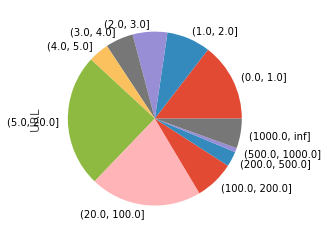

In [28]:
# Get the number of cells that are missing producer information
# for each new_song_artist and sort by artist with most missing.

df_none_listed_counts_per_artist = df[df.new_song_producer == "None Listed" ].\
    groupby("new_song_artist").\
    count()['URL'].sort_values(ascending = False)

# bin the none_listed_counts_per_artist, and take the mean and count
# of each bin

mean_per_bin = df_none_listed_counts_per_artist.groupby(
    pd.cut(df_none_listed_counts_per_artist, [0,1, 2,3,4,5, 20, 100,200, 500, 1000,np.infty])).\
    mean()

counts_per_bin = df_none_listed_counts_per_artist.value_counts().groupby(
    pd.cut(df_none_listed_counts_per_artist.value_counts().
    index, [0,1, 2,3,4,5, 20, 100,200, 500, 1000,np.infty])).\
    sum()

# #Mulitply together to the number of missing values 

num_cells_missing_prod_by_num_artist = mean_per_bin * counts_per_bin

# This has the correct sum, showing that this methodology was successful.

_ = num_cells_missing_prod_by_num_artist.plot(kind='pie')


# Replace "None Listed" in new_song_producer with new_song_artist

In [217]:
#Replace none_listed in new_song_producer with NA

df.new_song_producer = df.new_song_producer.replace("None Listed", np.nan)

#Count number of NA in new_song_producer per new_song_artist. 
#Had to create a new dataframe in the process.
#Then join the 2 dataframes, and drop the extra columns formed by the join.
df2 = df['new_song_producer'].isnull()\
    .groupby(df['new_song_artist'])\
    .sum().astype(int).reset_index(name='num_producer_missing_per_artist')


df = df.join(df2.set_index('new_song_artist'), on ='new_song_artist', lsuffix='l')

#This line wasn't necessary the second time- not sure why
#df.drop(columns = ['num_producer_missing_per_artistl', '2'], inplace = True)

# Split the data into 2016 after and before.


In [4]:
# What percentage of the data is 2018, 2017, etc?

np.cumsum(df.groupby('new_song_year').count()['URL'].apply(
    lambda x: (x / len(df)) * 100 ).sort_index(
    ascending = False))

# If we take the data past 2016-2019 as our test set, we get about 5%.

new_song_year
2019      0.127584
2018      1.752243
2017      3.614425
2016      5.619121
2015      8.069004
2014     10.856848
2013     14.537780
2012     18.091127
2011     21.231863
2010     24.333238
2009     26.670467
2008     29.158353
2007     31.654383
2006     34.037759
2005     36.783528
2004     39.245626
2003     41.907244
2002     44.100601
2001     46.638707
2000     49.208030
1999     52.375911
1998     55.539721
1997     58.646525
1996     62.246020
1995     65.739647
1994     70.241731
1993     74.872755
1992     80.081979
1991     84.847374
1990     88.833693
           ...    
1982     98.813741
1981     98.892463
1980     98.946754
1979     99.013261
1978     99.082482
1977     99.134058
1976     99.201922
1975     99.280644
1974     99.363438
1973     99.455732
1972     99.523596
1971     99.611819
1970     99.686469
1969     99.771978
1968     99.857486
1967     99.892775
1966     99.929422
1965     99.940280
1964     99.944352
1963     99.951138
1962     99.96335

In [280]:
test = df[df.new_song_year > 2014]
train = df[df.new_song_year < 2015]
print(test.shape)
print(train.shape)

(5945, 18)
(67732, 18)


In [297]:
# Songs and users have to be in both, right?

#get intersection of sampled_artist and song_producer from train and test set
def get_intersection_of_train_and_test_set(train, test, column):
    
    '''
    Takes train and test set and a column, and returns both filtered
    to have values they both share
    '''
    test_column = set(test[column])
    train_column = set(train[column])
    both_columns = test_column.intersection(train_column)
    print([len(test_column), len(train_column), len(both_columns)])
    
    test = test[test[column].isin(list(both_columns))]

    train = train[train[column].isin(list(both_columns))]
    
    return train, test

train, test = get_intersection_of_train_and_test_set(
    train, test, "sampled_artist")
train, test = get_intersection_of_train_and_test_set(
    train, test, "new_song_producer")

#I needed to run this 3 times to work

#I have 1163 artists, and 544 producers shared. 

[1163, 1164, 1163]
[544, 544, 544]
